In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import functools
import numbers
from IPython import display
import time
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchvision
from PIL import Image
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms
import skimage
from skimage.transform import resize as res1
from sklearn.metrics import f1_score
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)

def use_svg_display():
    """Use the svg format to display a plot in Jupyter.

    Defined in :numref:`sec_calculus`"""
    display.set_matplotlib_formats('svg')


class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()


class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        self.num_axes = nrows * ncols
        if self.num_axes == 1:
            self.axes = [self.axes, ]
        xlabel = self._repeat_arg_if_not_iterable(xlabel)
        ylabel = self._repeat_arg_if_not_iterable(ylabel)
        legend = self._repeat_arg_if_not_nested_iterable(legend)
        xlim = self._repeat_arg_if_not_nested_iterable(xlim)
        ylim = self._repeat_arg_if_not_nested_iterable(ylim)
        xscale = self._repeat_arg_if_not_nested_iterable(xscale)
        yscale = self._repeat_arg_if_not_nested_iterable(yscale)
        # Bind arguments with functools
        self.config_axes = [functools.partial(set_axes, self.axes[i], xlabel[i], ylabel[i], 
            xlim[i], ylim[i], xscale[i], yscale[i], legend[i]) for i in range(self.num_axes)]
        self.fmts = fmts
        self.X, self.Y = [None] * self.num_axes, [None] * self.num_axes

    def add(self, x, y):
        if self.num_axes == 1:
            x = [x,]
            y = [y,]
        x = self._repeat_arg_if_not_iterable(x)
        y = self._repeat_arg_if_not_iterable(y)
        for ax_idx, (ax, config_ax, ax_x, ax_y) in enumerate(zip(self.axes, self.config_axes, x, y)):
            # Add multiple data points into the figure
            if not hasattr(ax_y, "__len__"):
                ax_y = [ax_y]
            n = len(ax_y)
            if not hasattr(ax_x, "__len__"):
                ax_x = [ax_x] * n
            if not self.X[ax_idx]:
                self.X[ax_idx] = [[] for _ in range(n)]
            if not self.Y[ax_idx]:
                self.Y[ax_idx] = [[] for _ in range(n)]
            for i, (a, b) in enumerate(zip(ax_x, ax_y)):
                if a is not None and b is not None:
                    self.X[ax_idx][i].append(a)
                    self.Y[ax_idx][i].append(b)
            ax.cla()
            for x, y, fmt in zip(self.X[ax_idx], self.Y[ax_idx], self.fmts):
                ax.plot(x, y, fmt)
            config_ax()
        display.display(self.fig)
        display.clear_output(wait=True)

    def _repeat_arg_if_not_iterable(self, arg):
        if arg is None or isinstance(arg, (str, numbers.Number)):
            return [arg] * self.num_axes
        else:
            return arg

    def _repeat_arg_if_not_nested_iterable(self, arg):
        if arg is None or isinstance(arg, str) or isinstance(arg[0], (numbers.Number, str)):
            return [arg] * self.num_axes
        else:
            return arg

def get_dataloader_workers():
    """Use 4 processes to read the data.

    Defined in :numref:`sec_fashion_mnist`"""
    return 4


def accuracy(y_hat, y):
    """Compute the number of correct predictions.

    Defined in :numref:`sec_softmax_scratch`"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)
    cmp = astype(y_hat, y.dtype) == y
    return float(reduce_sum(astype(cmp, y.dtype)))


def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU.

    Defined in :numref:`sec_lenet`"""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]


def evaluate_f1_gpu(net, data_iter, device=('cuda')):
    """Compute the f1 score for a model on a dataset using a GPU.

    Defined in :numref:`sec_lenet`"""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions

    
    y_tot =[]
    y_hat_tot = []

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            
            
            y_hat = net(X)
            
            y_tot  += y.cpu().data.numpy().tolist()
            y_hat_tot += argmax(y_hat.cpu(), axis=1).data.numpy().tolist()
            
    f1_measure = f1_score(y_tot, y_hat_tot, average="macro")
            

    return f1_measure, y_tot, y_hat_tot



In [2]:
class Resize_1:
    def __init__(self, size):
        if isinstance(size, int):
            self._size = (size, size)

    def change(self, img):
        resize_image = res1(img, self._size)
        # the resize will return a float64 array
        return resize_image

In [3]:
torch.cuda.is_available()

True

In [4]:
class myDataset_1(torch.utils.data.Dataset):
    """My dataset."""
    def __init__(self, images, labels, resize=None):
        """
        Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        """
        self.labels = labels
        self.images = images
        self.resize = resize
        self.res_func = Resize_1(resize)

    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        
        if self.resize:
            image = self.res_func.change(self.images[idx])
        else:
            image = self.images[idx]
            
        image = torch.tensor(image).reshape(-1, self.resize, self.resize).float()
        # read labels
        labels = torch.tensor(self.labels[idx]).long()
        sample = [image, labels]
        return sample

In [5]:
#This cell is used to load the pre-processed data saved after running pre-processing notebook
#In this case the training data augmented with some blur is loaded, hence the second model will train if the next cell are run
#Change this cell to train the model on the clear data
train_ds = myDataset_1(np.load('aug_train_x.npy'), np.load('aug_train_y.npy'), resize=224)
valid_ds = myDataset_1(np.load('aug_val_x.npy'), np.load('aug_val_y.npy'), resize=224)


In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class DenseNet(nn.Module):
    def __init__(self, num_labels=6):
        super(DenseNet, self).__init__()
        
        self.DenseNet = num_labels
        
        self.DenseNet = models.googlenet(pretrained=True)
        
        self.DenseNet.classifier = nn.Sequential(
        nn.Linear(in_features=1024, out_features=num_labels, bias=True)
  )
  
        

    def forward(self, pixel_values):
        outputs = self.DenseNet(pixel_values)

        return outputs

In [20]:
models.googlenet(pretrained=True)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [21]:
EPOCHS = 15
BATCH_SIZE = 32
LEARNING_RATE = 0.0001

In [22]:
 torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1060 6GB'

In [24]:
import torch.nn as nn
import torch

# Define Model

model = DenseNet(6)

for param in model.DenseNet.parameters():
    param.requires_grad = True

# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()
# Use GPU if available  
device = torch.device('cuda') 


In [12]:
import torch.utils.data as data

print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(valid_ds))

train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True) 

Number of train samples:  67368
Number of test samples:  19248


In [13]:
def trainf(net, train_iter, test_iter, loss_func, num_epochs, optimizer, device, scheduler=None, ylim=(None, (0, 1))):
    """Train and evaluate a model with CPU or GPU."""
    net.to(device)
    animator = Animator(xlabel='epoch', xlim=[0, num_epochs], ylim=ylim,
                        legend=[['train loss'], ['train acc', 'train f1', 'val acc', 'val f1'] ],
                        nrows=1, ncols=2, figsize=(10, 4))
    
    animator.add(0, [None, (0, 0, 0, 0)])
    column_names=["Epoch", "Training Loss", "Training Accuracy", "Training F1 Score", "Validation Accuracy", "Validation F1 Score"]
    column_new = ['Epoch', 'Training Loss','Training Accuracy','Training F1']
    metric_dict =  pd.DataFrame([[0,0,0,0,0,0]], columns=column_names)
    dict_dik = pd.DataFrame([[0,0,0,0]],columns=column_new)
    timer = Timer()
    for epoch in range(num_epochs):
        metric = Accumulator(4)  # train_loss, train_acc, train_f1, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            loss = loss_func(y_hat, y)
            loss.backward()
            optimizer.step()
            
            
            
            with torch.no_grad():
                metric.add(loss*X.shape[0], accuracy(y_hat, y), f1_score(y.cpu(), argmax(y_hat.cpu(), axis=1), average='macro'), X.shape[0])
            timer.stop()
            train_loss, train_acc, train_f1 = metric[0]/metric[3], metric[1]/metric[3], metric[2]/(i+1)
            if (i+1) % 48 == 0:
                new_row = {"Epoch":epoch+1, "Training Loss":train_loss, "Training Accuracy":train_acc , "Training F1 Score":train_f1}
                dict_dik = dict_dik.append(new_row, ignore_index=True)
                print(f'epoch {epoch:.0f}, step {(i+1):.0f}, training loss {train_loss:.5f}, train acc {train_acc:.5f}, train f1 {train_f1:.5f}'+'\n')
                animator.add(epoch + i/len(train_iter), [train_loss, (train_acc, train_f1, None, None)])
                

        if scheduler:
            scheduler.step()
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        test_f1, _, _ = evaluate_f1_gpu(model, test_loader)
        #metric_dict[("Epoch "+str(epoch))] = 'training loss : '+str(round(train_loss, 5))+' ,train acc : '+str(round(train_acc, 5))+' ,train f1 : '+str(round(train_f1, 5))+' ,test acc : '+str(round(test_acc, 5)+' ,test f1 : '+str(round(test_f1, 5)))
        new_row = {"Epoch":epoch+1, "Training Loss":train_loss, "Training Accuracy":train_acc , "Training F1 Score":train_f1 , "Validation Accuracy":test_acc, "Validation F1 Score":test_f1}
        metric_dict = metric_dict.append(new_row, ignore_index=True)
        print(f'epoch {epoch:.0f}, training loss {train_loss:.5f}, train acc {train_acc:.5f}, train f1 {train_f1:.5f}, val acc {test_acc:.5f}, val f1 {test_f1:.5f}'+'\n')
        animator.add(epoch + 1, [None, (None, None, test_acc, test_f1)])
        
    

    print("")
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec 'f'on {str(device)}')
    print("")
    
    metric_dict = metric_dict.drop([0])
    
    return metric_dict,dict_dik
    
    


5.7 examples/sec on cuda

Wall time: 7h 8min 30s


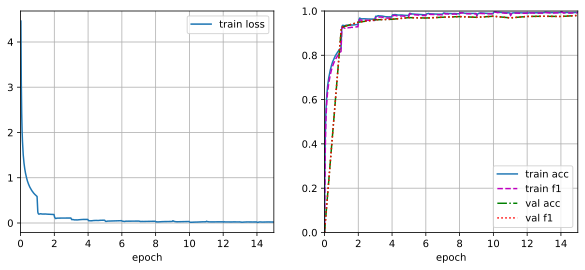

In [13]:
%%time
#This cell is used to train the model
#As we can see from the output it took more than 7 hours to train the second model of this study
tr_df,my_df = trainf(model, train_loader,test_loader , loss_func, EPOCHS, optimizer, device)

In [14]:
tr_df

,Epoch,Training Loss,Training Accuracy,Training F1 Score,Validation Accuracy,Validation F1 Score
1,1.0,0.579332,0.834833,0.819336,0.926174,0.926485
2,2.0,0.187390,0.938576,0.928622,0.949241,0.949283
3,3.0,0.108591,0.963811,0.957733,0.960204,0.960293
4,4.0,0.078871,0.973177,0.967462,0.962645,0.962694
5,5.0,0.060408,0.980154,0.976306,0.970127,0.970172
6,6.0,0.050675,0.982514,0.979071,0.968360,0.968289
7,7.0,0.041906,0.985616,0.982726,0.971945,0.971970
8,8.0,0.037634,0.987472,0.984632,0.974751,0.974791
9,9.0,0.033693,0.988689,0.986592,0.971530,0.971532
10,10.0,0.032368,0.989105,0.987049,0.976361,0.976344


In [15]:
#model is saved
torch.save(model, "augmentedGoogleNet_15epoch_32bs_0.0001lr.pt")

In [16]:
tr_df.to_csv('augmentedGoogleNet_15epoch_32bs_0.0001lr', sep='\t',encoding='utf-8')

In [17]:
my_df.to_csv('augmentedGoogleNet_15epoch_32bs_0.0001lr.csv', sep='\t',encoding='utf-8')

In [14]:
#loading testing set of second model

ds_test = myDataset_1(np.load('aug_test_x.npy'), np.load('aug_test_y.npy'), resize=224)

In [15]:
test_loader  = data.DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=True)

In [25]:
mod1 = torch.load("augmentedGoogleNet_15epoch_32bs_0.0001lr.pt")

In [26]:
#accuracy of second model on its test set
evaluate_accuracy_gpu(mod1, test_loader)

C:\Users\user\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0.980257689110557

In [27]:
test_f1, y_t, y_h_t = evaluate_f1_gpu(mod1, test_loader)

In [28]:
#F1-Score of second model on its test set
test_f1

0.9802762984365675

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [32]:
#Cell used to evaluate results of the study
#In this case the deployment clear images are loaded, then tested on the first model
#Change dataset and model to experiment on different level of blur using the two models

ds_test = myDataset_1(np.load('x_deployment.npy'), np.load('y_deployment.npy'), resize=224)

test_loader  = data.DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=True)

mod1 = torch.load("newGoogleNet_15epoch_32bs_0.0001lr.pt")



In [33]:
#Accuracy of baseline model on clear deployment data
evaluate_accuracy_gpu(mod1, test_loader)

0.5564444444444444

In [34]:
#F1-Score of baseline model on clear deployment data
test_f1, y_t, y_h_t = evaluate_f1_gpu(mod1, test_loader)

test_f1

0.5266553470868347

Normalized confusion matrix
[[0.76 0.   0.01 0.11 0.08 0.02]
 [0.01 0.03 0.   0.84 0.09 0.02]
 [0.07 0.01 0.47 0.25 0.07 0.13]
 [0.   0.   0.01 0.95 0.01 0.03]
 [0.07 0.03 0.02 0.27 0.46 0.15]
 [0.01 0.01 0.03 0.24 0.04 0.67]]


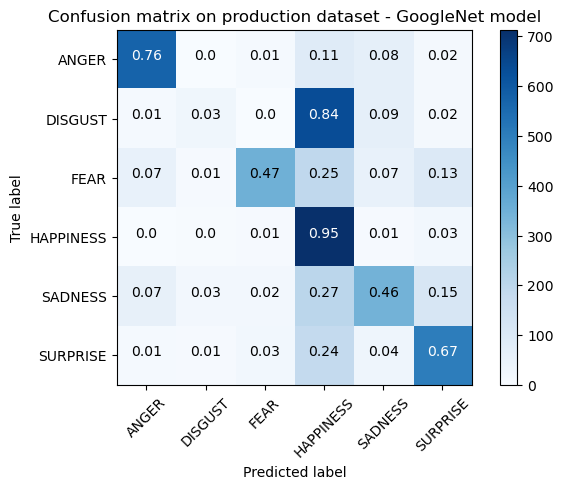

In [35]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_t, y_h_t)
np.set_printoptions(precision=2)


plt.figure()
cls_names = ['ANGER', 'DISGUST', 'FEAR', 'HAPPINESS', 'SADNESS', 'SURPRISE']
plot_confusion_matrix(cnf_matrix, classes=cls_names,normalize=True, title='Confusion matrix on production dataset - GoogleNet model')
plt.show()
plt.close()


([<matplotlib.axis.XTick at 0x1499eff69a0>,
 [Text(1, 0, 'No blur'),
  Text(2, 0, 'Low blur'),
  Text(3, 0, 'Medium blur'),
  Text(4, 0, 'High blur'),
  Text(5, 0, 'Very high blur')])

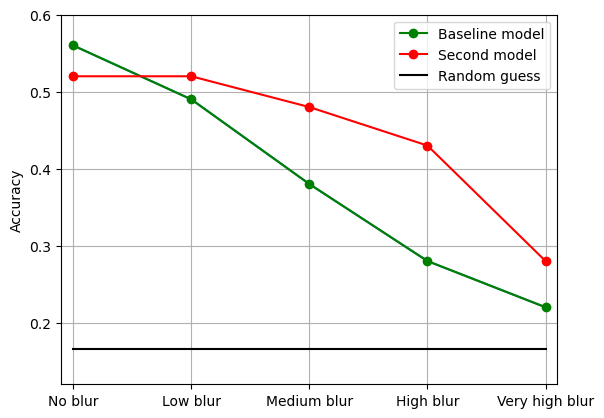

In [30]:
#Results plotted
x = [1, 2, 3, 4, 5]
y = [0.56, 0.49, 0.38, 0.28, 0.22]
y2 = [0.52, 0.52, 0.48, 0.43, 0.28]
l = ['No blur', 'Low blur', 'Medium blur', 'High blur', 'Very high blur']

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xticks(x, labels=l)
plt.xlim(0.9, 5.1), plt.ylim(0.12, 0.6)
plt.grid()
plt.ylabel('Accuracy')
plt.plot(x, y, marker='o', label='Baseline model', color='green')
plt.plot(x, y2, marker='o', label='Second model', color='red')
plt.plot(x, [0.166, 0.166, 0.166, 0.166, 0.166], color='black', label='Random guess')
plt.legend()
plt.xticks(x, labels=l)